In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 7  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'urw_stats_10-31-24'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'long_run'

det_single = 'urw_inter'

# file_nums = list(range(0, 6))
file_nums = 'all'

noise_sigma = 5

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 237/237 [00:24<00:00,  9.76it/s]


In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [5]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, save_waveforms=False)
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 600, 'resist_1': 410}
Reading in data...


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Read in data shape: (217827, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


Fitting time: 3.547158718109131 s
Processed sub-chunk 1/1
Processed chunk 1/3


100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


Read in data shape: (219790, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


Fitting time: 4.0998594760894775 s
Processed sub-chunk 1/1
Processed chunk 2/3


100%|██████████| 37/37 [00:08<00:00,  4.55it/s]


Read in data shape: (81718, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:01<00:00, 13.68it/s]


Fitting time: 1.8863904476165771 s
Processed sub-chunk 1/1
Processed chunk 3/3
Getting hits...
Hits shape: (519335, 256)


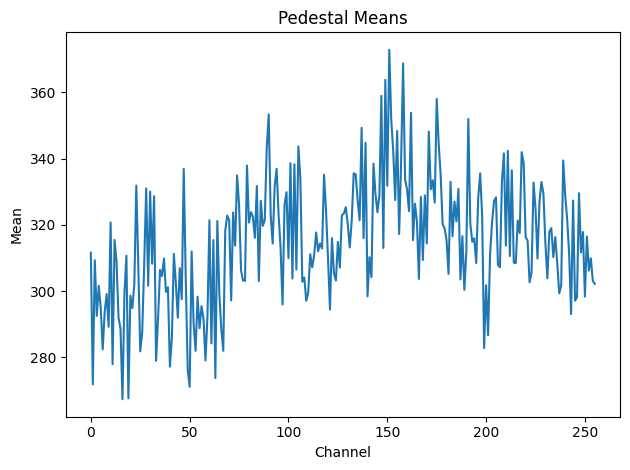

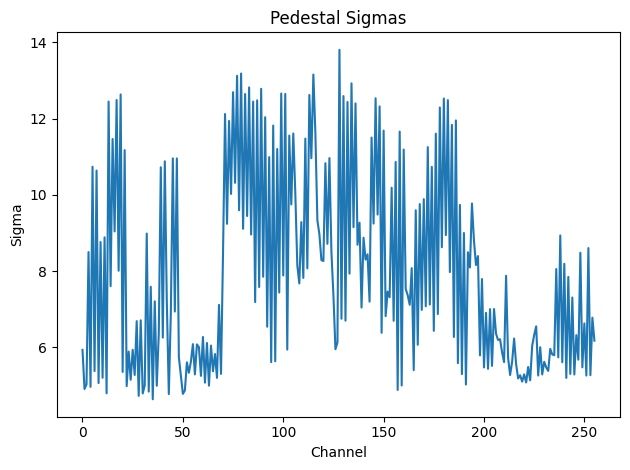

In [6]:
det.dream_data.plot_pedestals()

/home/dylan/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:699: RuntimeWarning: invalid value encountered in divide
  max_amp_div_sum = event_max_amps / event_amp_sums


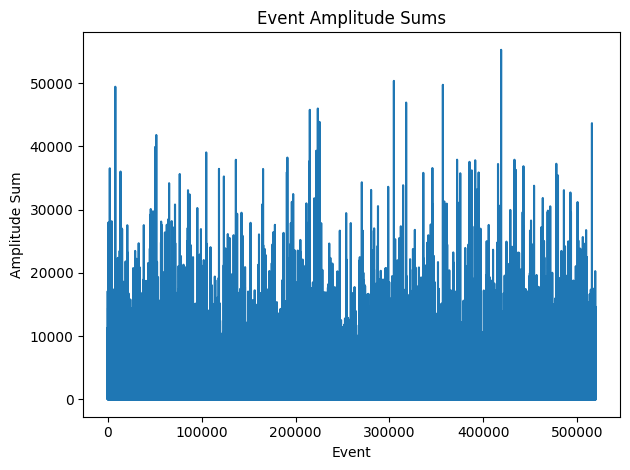

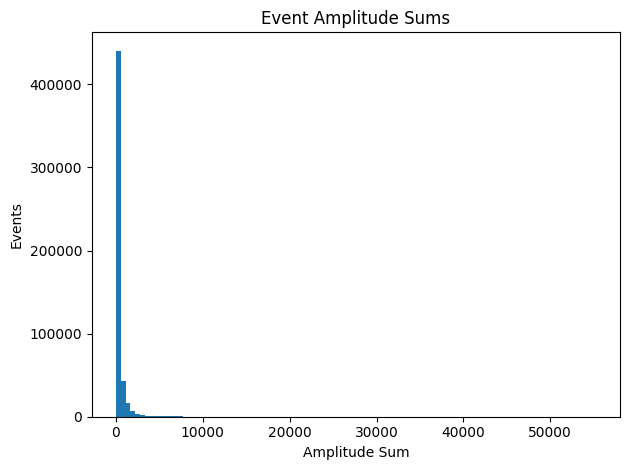

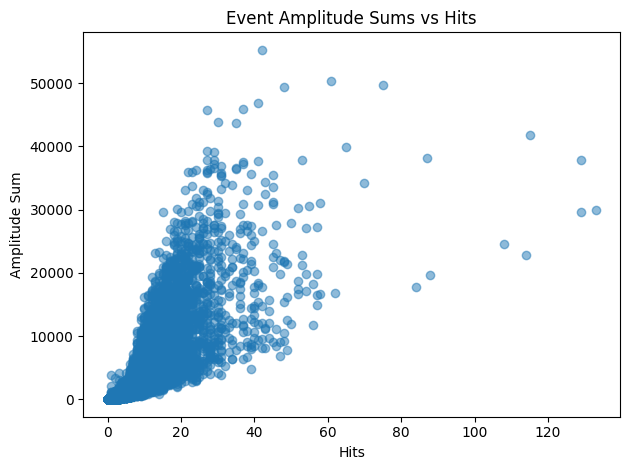

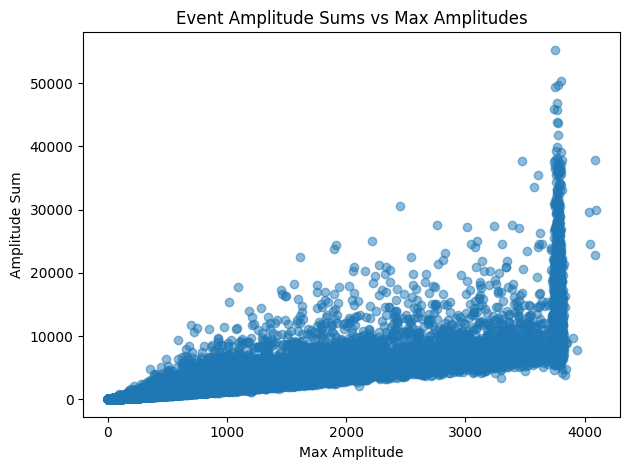

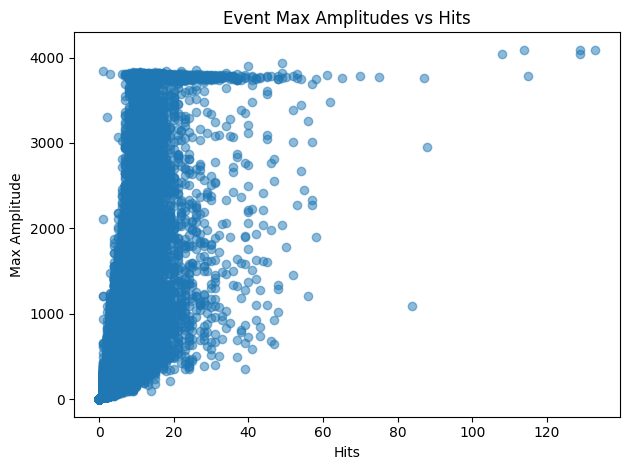

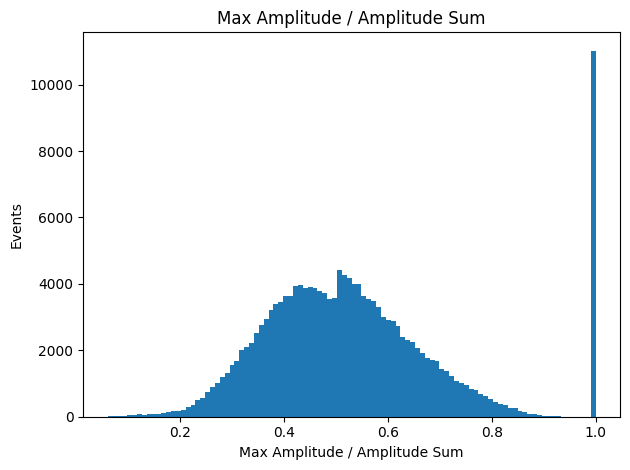

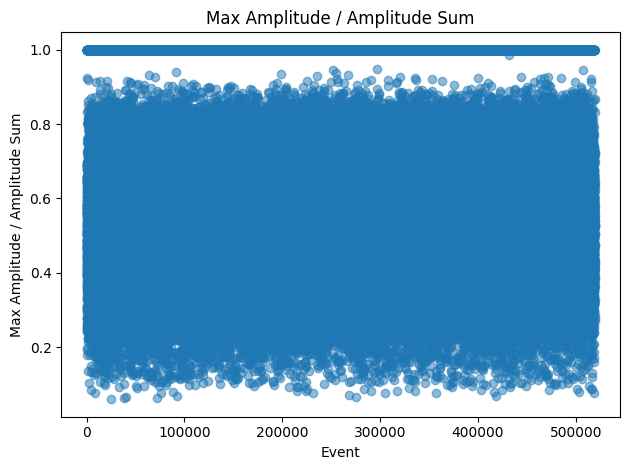

In [7]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Connector 2 Dead Strips: [116 117 118 119 120 121 122 123 124 125 126 127]
Connector 3 Dead Strips: [128 129 130 131 132 133 134 135 136 137]
Connector 4 Dead Strips: [215 225 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


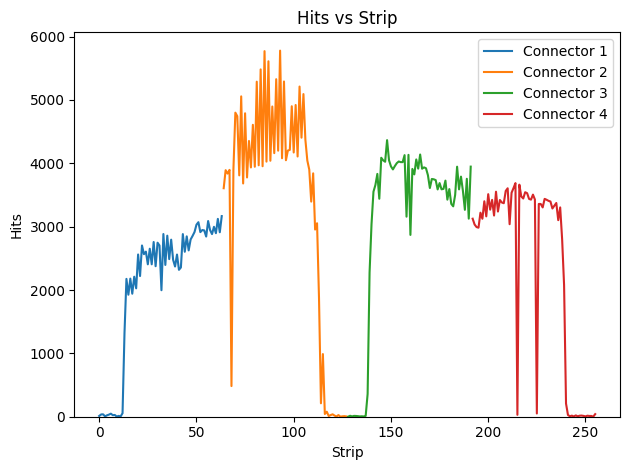

In [8]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

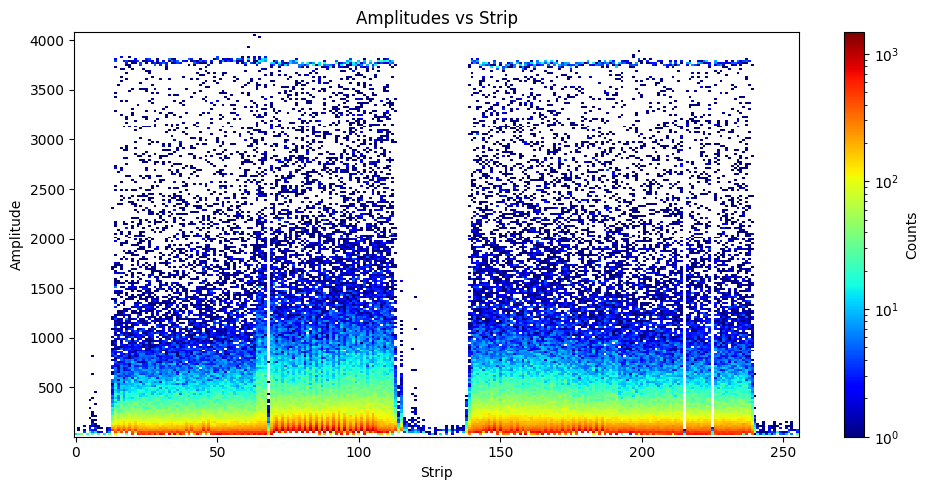

In [9]:
det.dream_data.plot_amplitudes_vs_strip()

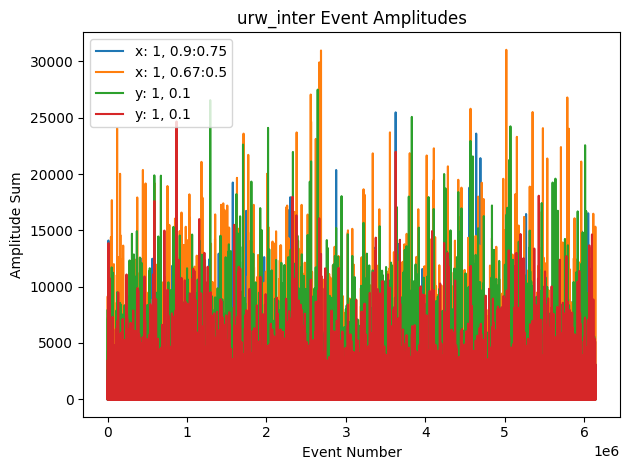

In [10]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

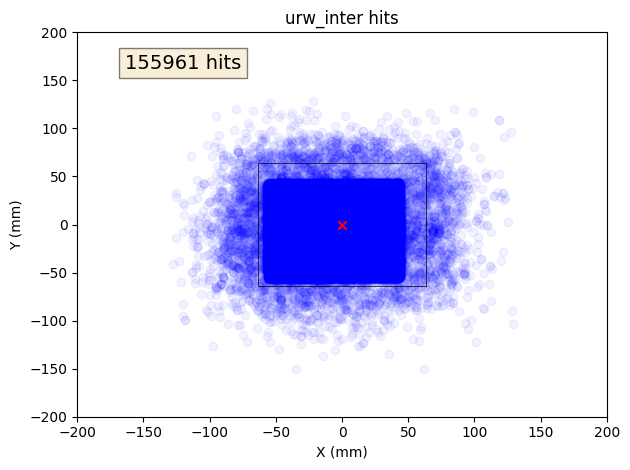

In [11]:
plot_ray_hits_2d(det, ray_data)

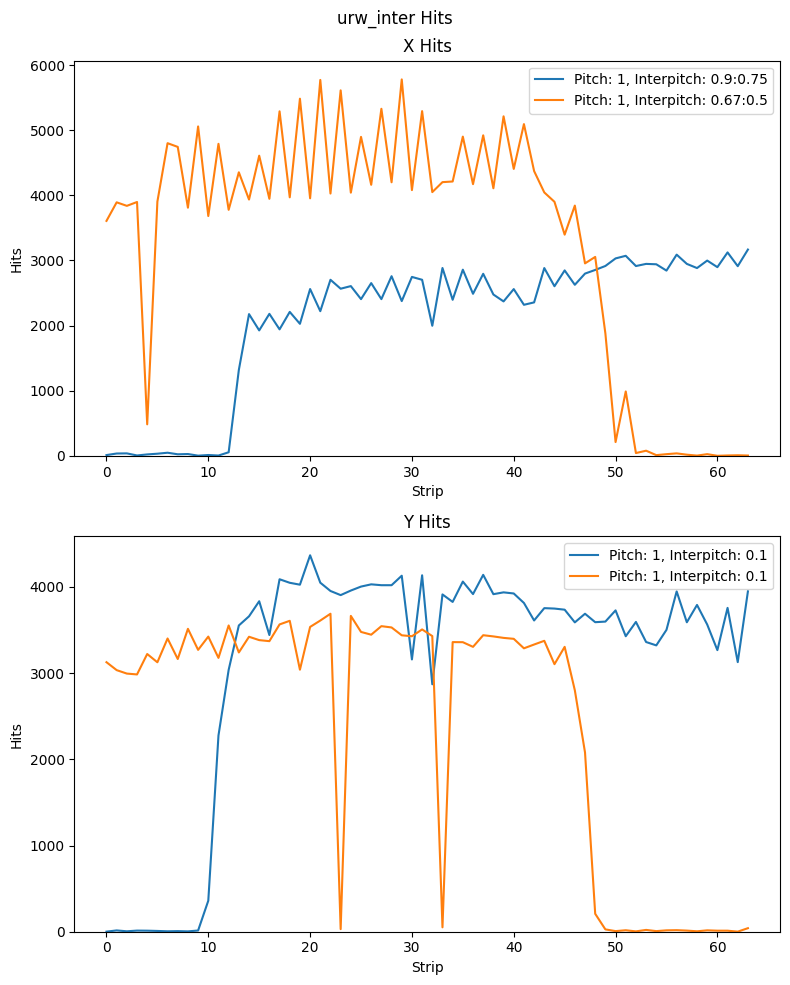

In [12]:
det.plot_hits_1d()

In [13]:
print(len(det.dream_data.hits))

519335


In [14]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

z: 697.0
z: 697.3448275862069
z: 697.6896551724138
z: 698.0344827586207
z: 698.3793103448276
z: 698.7241379310345
z: 699.0689655172414
z: 699.4137931034483
z: 699.7586206896551
z: 700.1034482758621
z: 700.448275862069
z: 700.7931034482758
z: 701.1379310344828
z: 701.4827586206897
z: 701.8275862068965
z: 702.1724137931035
z: 702.5172413793103
z: 702.8620689655172
z: 703.2068965517242
z: 703.551724137931
z: 703.8965517241379
z: 704.2413793103449
z: 704.5862068965517
z: 704.9310344827586
z: 705.2758620689655
z: 705.6206896551724
z: 705.9655172413793
z: 706.3103448275862
z: 706.6551724137931
z: 707.0
z_rot: -1.0
z_rot: -0.9310344827586207
z_rot: -0.8620689655172413
z_rot: -0.7931034482758621
z_rot: -0.7241379310344828
z_rot: -0.6551724137931034
z_rot: -0.5862068965517242
z_rot: -0.5172413793103449
z_rot: -0.4482758620689655
z_rot: -0.3793103448275862
z_rot: -0.31034482758620685
z_rot: -0.24137931034482762
z_rot: -0.1724137931034483
z_rot: -0.10344827586206895
z_rot: -0.034482758620689724
z

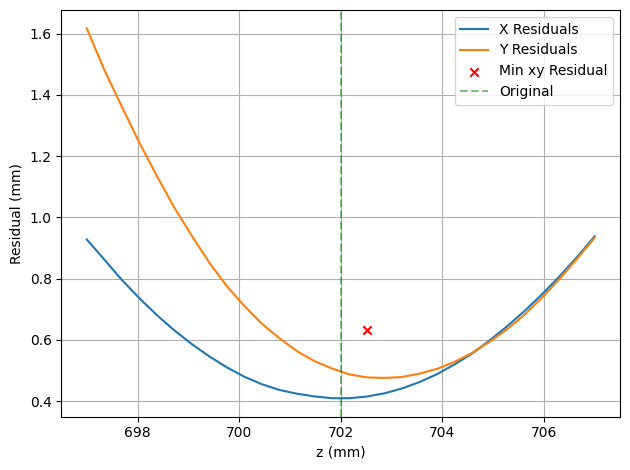

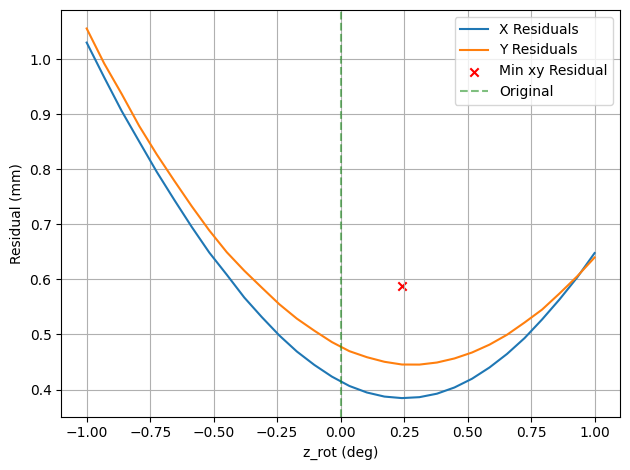

In [15]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

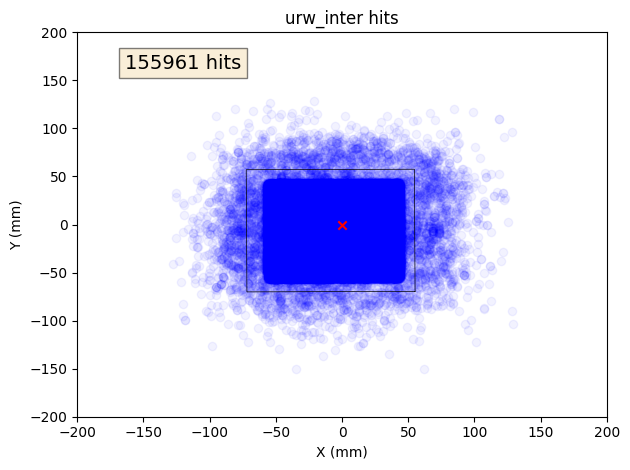

In [16]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 1630227
All rays: 377596


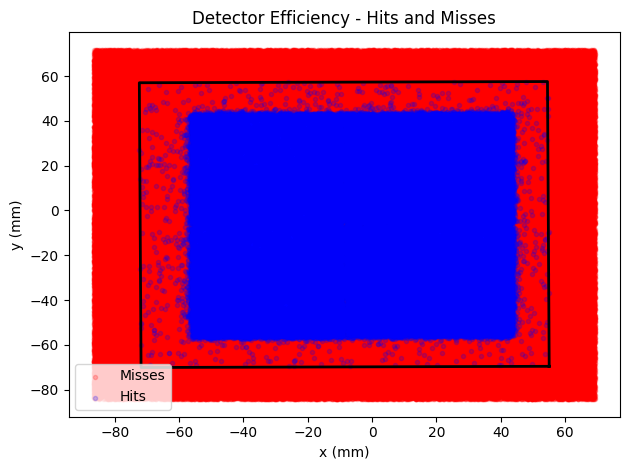

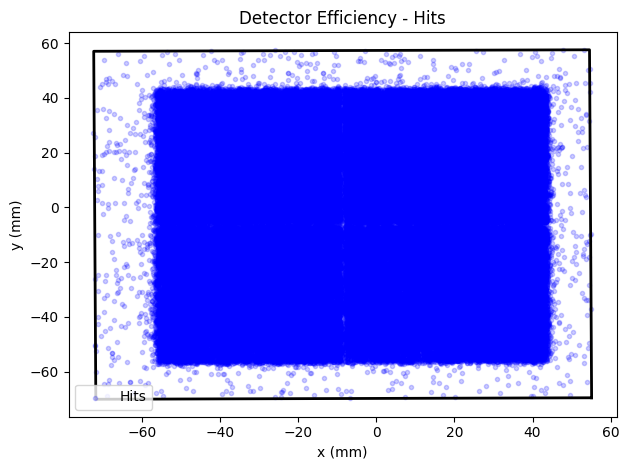

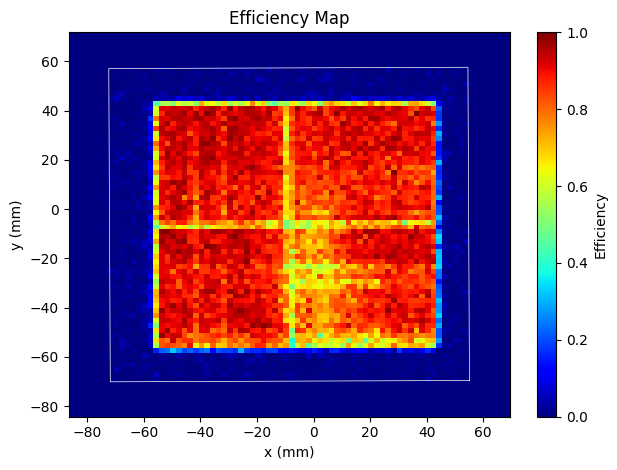

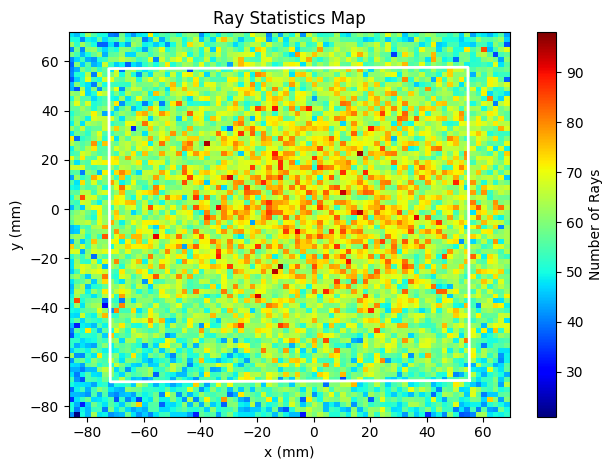

In [17]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=2)

/home/dylan/PycharmProjects/saclay_micromegas/poc/det_classes_test.py:1460: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


X Residuals: Mean=-3μm, Std=405μm
Y Residuals: Mean=-12μm, Std=449μm
X Residuals: Mean=-5μm, Std=445μm
Y Residuals: Mean=25μm, Std=451μm
X Residuals: Mean=0μm, Std=413μm
Y Residuals: Mean=-23μm, Std=500μm
X Residuals: Mean=5μm, Std=459μm
Y Residuals: Mean=12μm, Std=506μm


(-0.0016572744366625054,
 -0.0004550688608632512,
 0.3694157565149173,
 0.4328351110427749)

/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


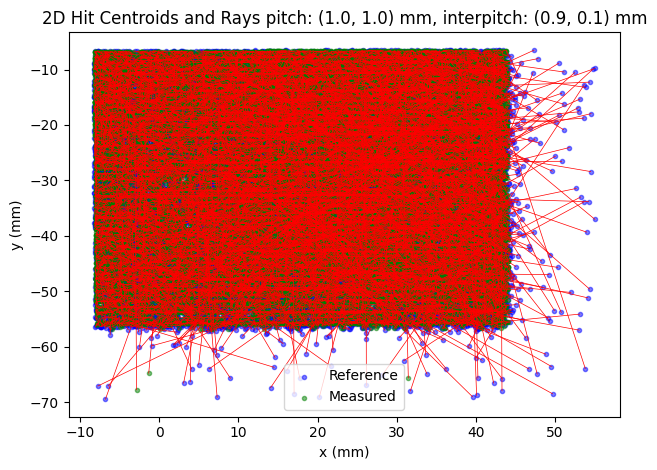

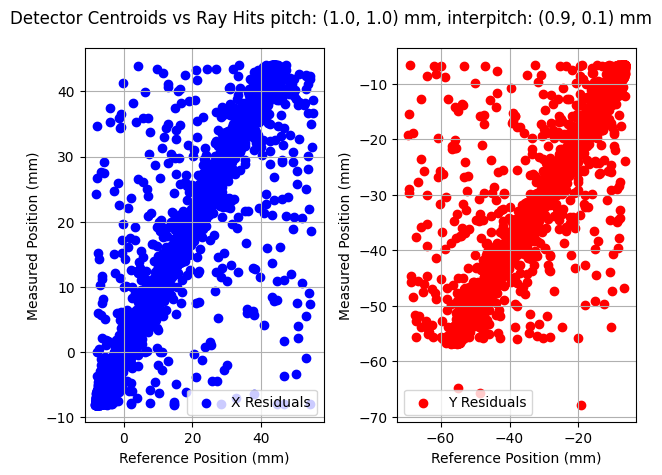

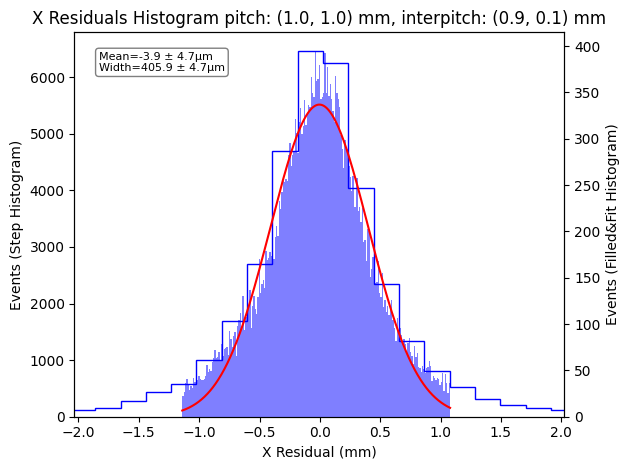

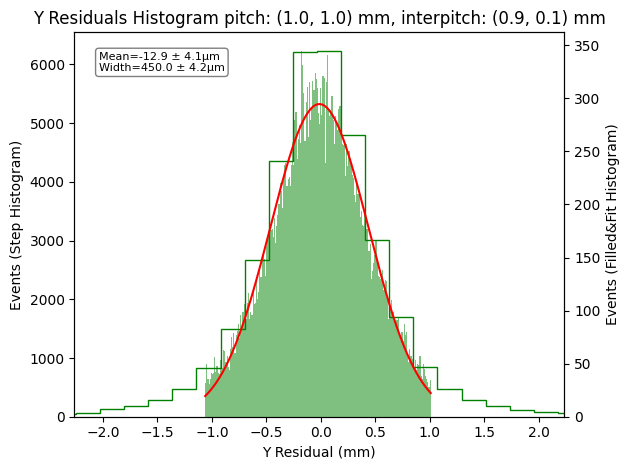

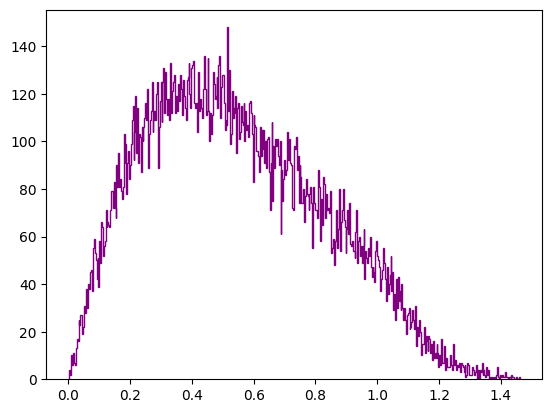

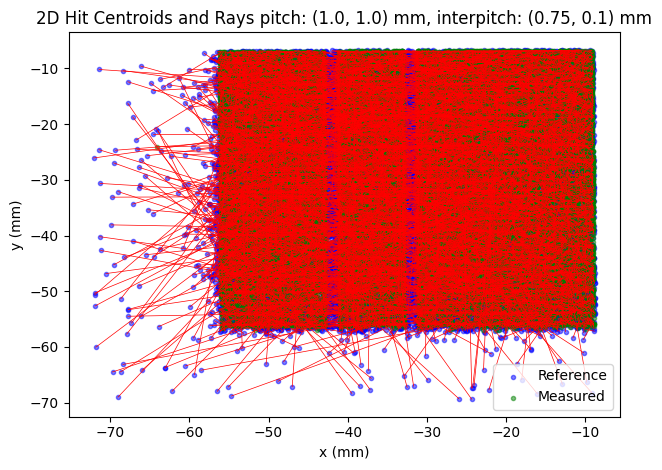

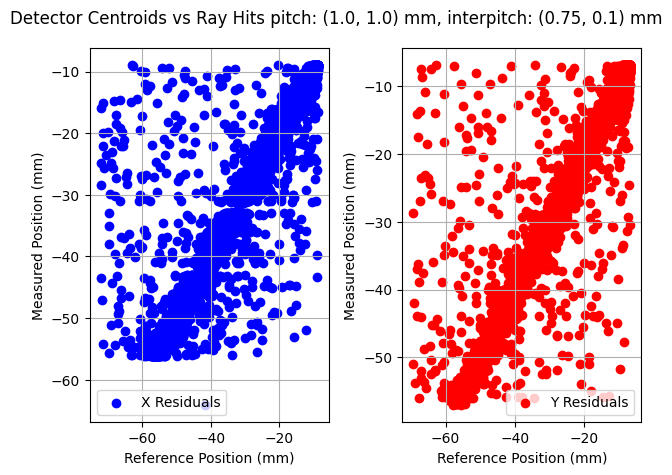

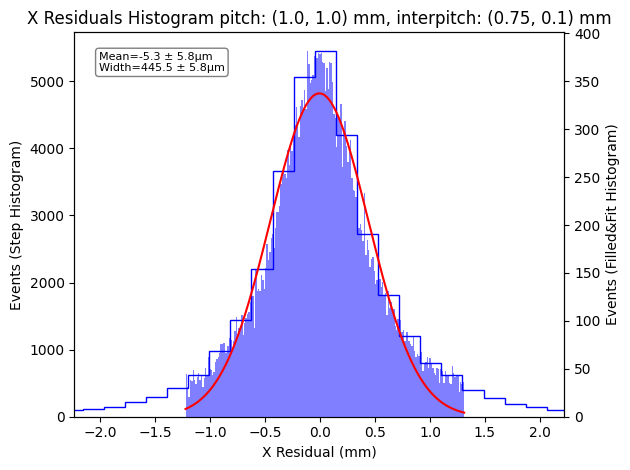

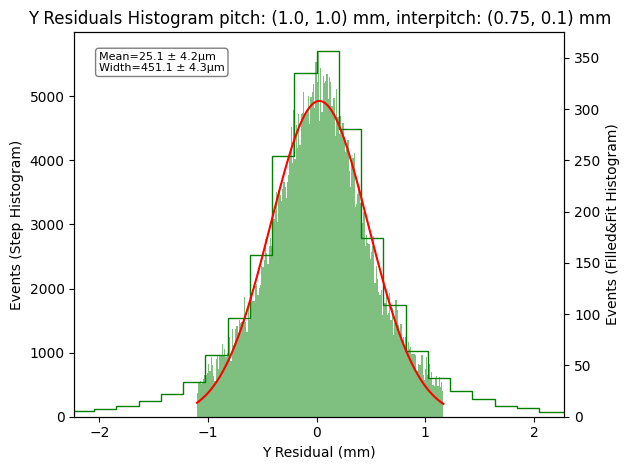

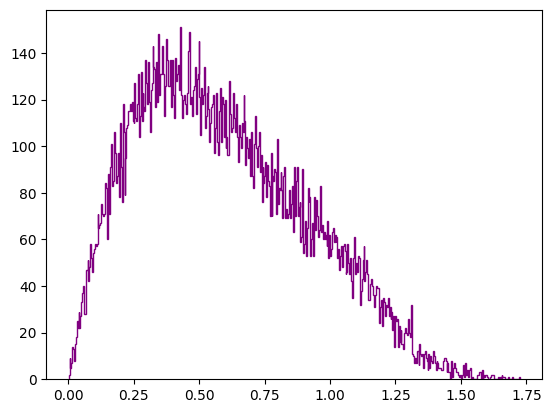

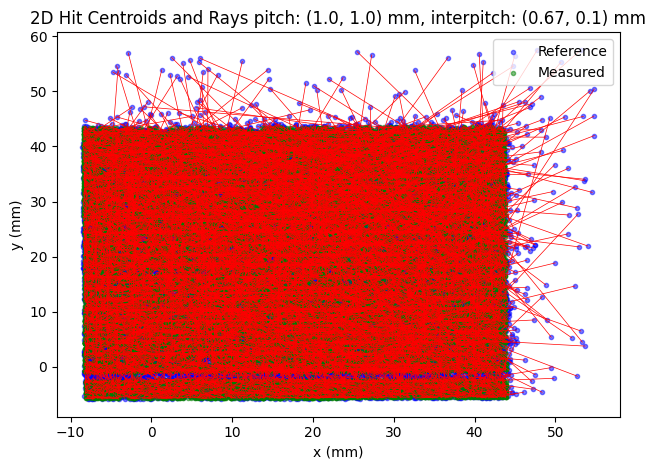

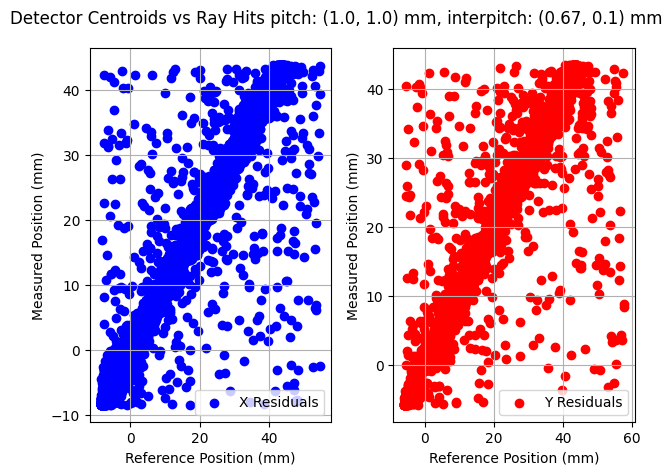

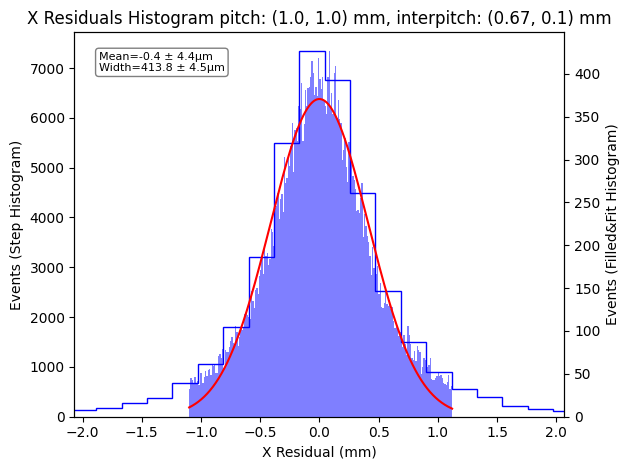

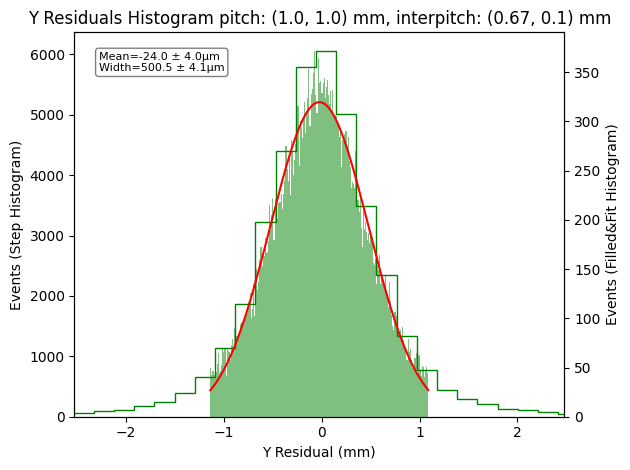

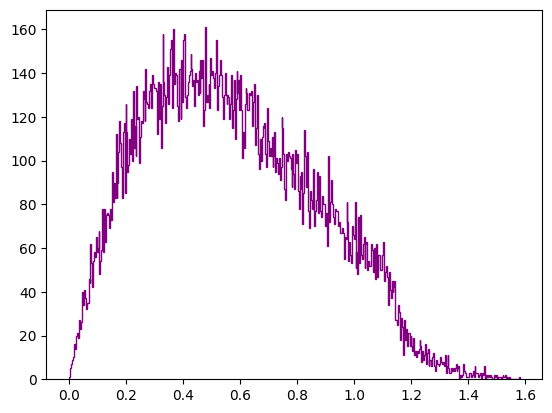

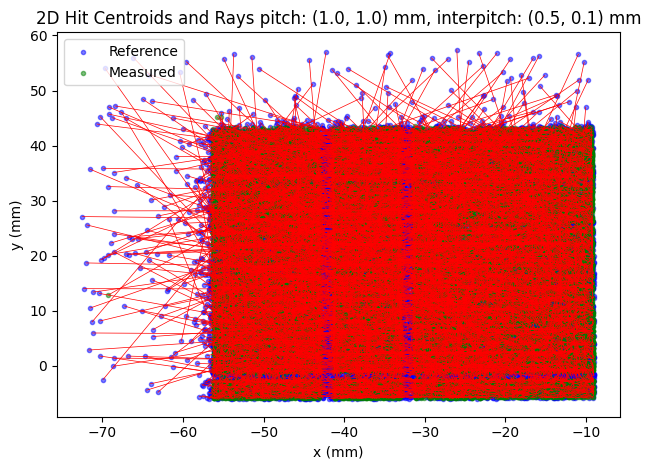

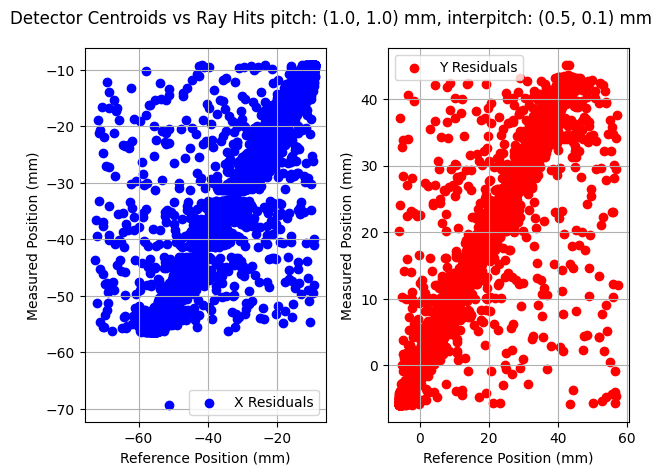

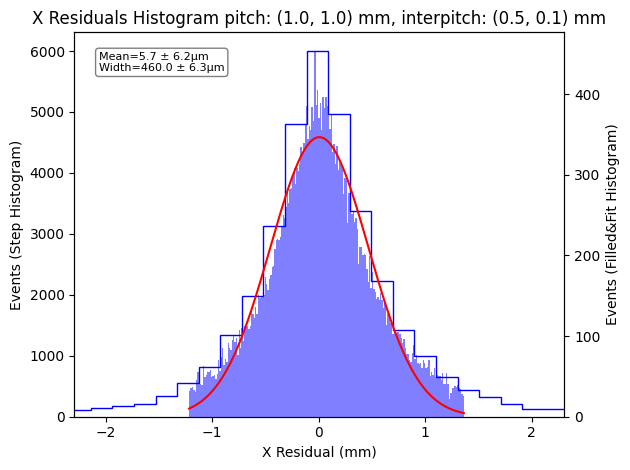

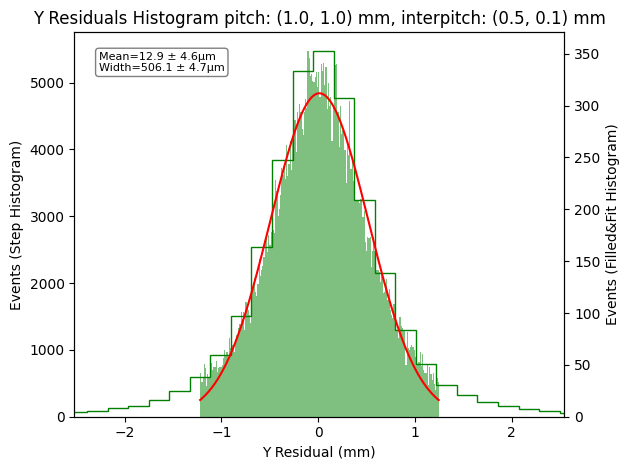

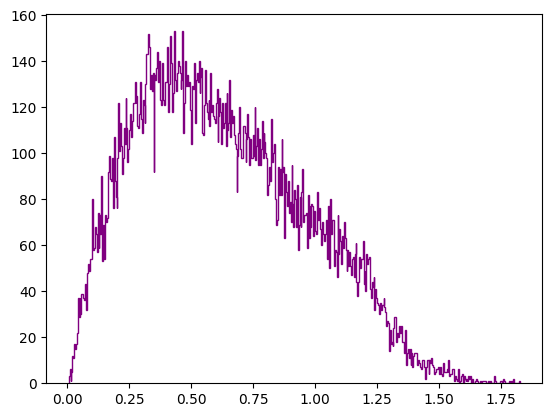

In [18]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [19]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.0          0.90           0.1 -0.003939    0.004719   
1      1.0      1.0          0.75           0.1 -0.005265    0.005776   
2      1.0      1.0          0.67           0.1 -0.000450    0.004426   
3      1.0      1.0          0.50           0.1  0.005669    0.006219   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.449998    0.004213  0.405922   0.004749  0.449998   0.004213  
1  0.451081    0.004304  0.445467   0.005800  0.451081   0.004304  
2  0.500514    0.004136  0.413807   0.004460  0.500514   0.004136  
3  0.506140    0.004721  0.459958   0.006252  0.506140   0.004721  


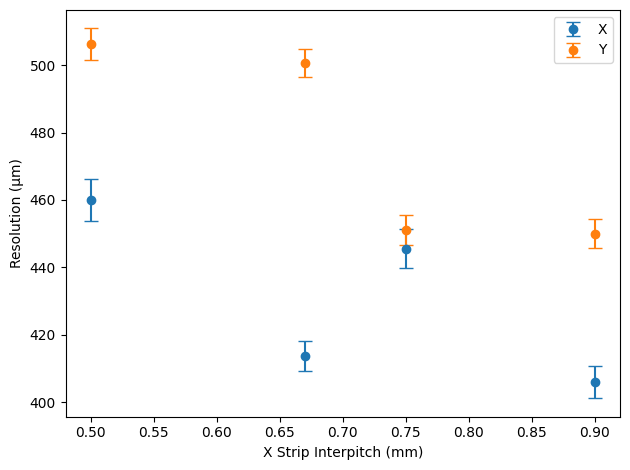

In [20]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.0          0.90           0.1 -0.003380    0.004004   
1      1.0      1.0          0.75           0.1 -0.006245    0.004721   
2      1.0      1.0          0.67           0.1  0.000111    0.003919   
3      1.0      1.0          0.50           0.1  0.004487    0.005215   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.439056    0.004519  0.392750   0.004127  0.439056   0.004519  
1  0.431688    0.004218  0.425776   0.004869  0.431688   0.004218  
2  0.487182    0.004448  0.399257   0.004062  0.487182   0.004448  
3  0.485246    0.004725  0.436042   0.005400  0.485246   0.004725  


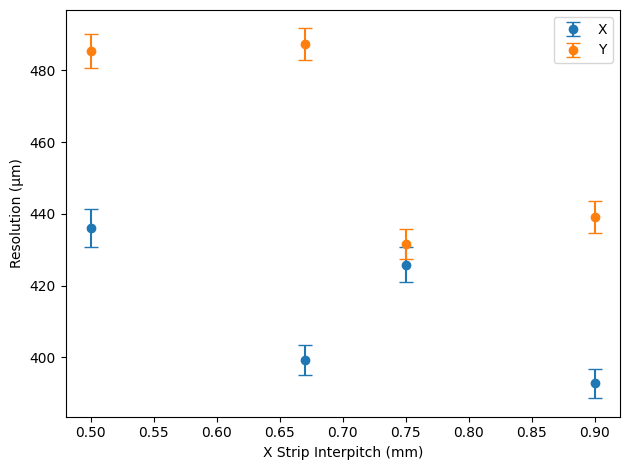

In [21]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.0          0.90           0.1 -0.003380    0.004004   
1      1.0      1.0          0.75           0.1 -0.006245    0.004721   
2      1.0      1.0          0.67           0.1  0.000111    0.003919   
3      1.0      1.0          0.50           0.1  0.004487    0.005215   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.439056    0.004519  0.392750   0.004127  0.439056   0.004519  
1  0.431688    0.004218  0.425776   0.004869  0.431688   0.004218  
2  0.487182    0.004448  0.399257   0.004062  0.487182   0.004448  
3  0.485246    0.004725  0.436042   0.005400  0.485246   0.004725  


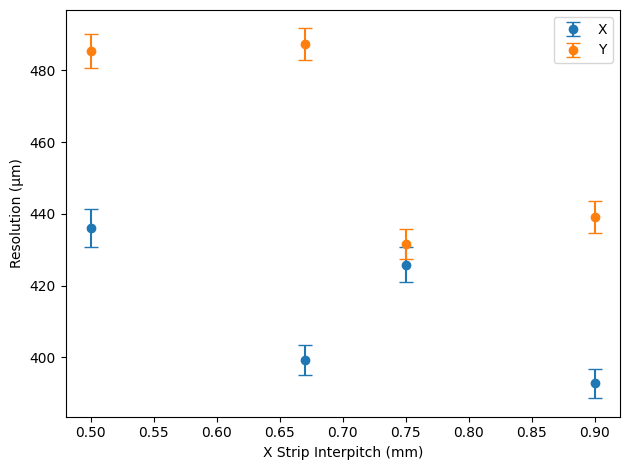

In [22]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

Rays in sub-detector 0: 56067, total rays: 1630227
Rays in sub-detector 1: 54232, total rays: 1630227
Rays in sub-detector 2: 58736, total rays: 1630227
Rays in sub-detector 3: 56901, total rays: 1630227


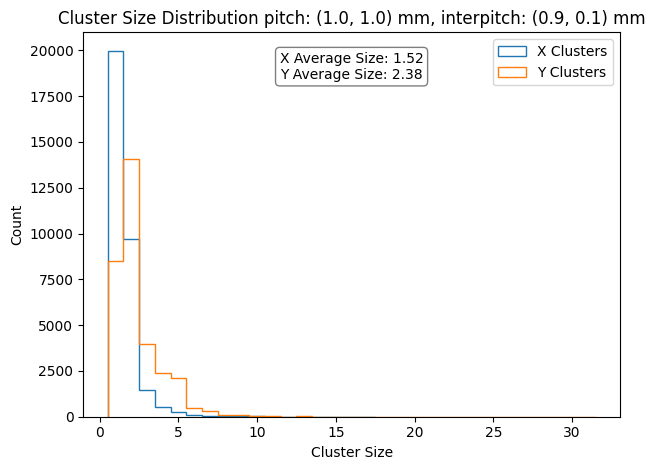

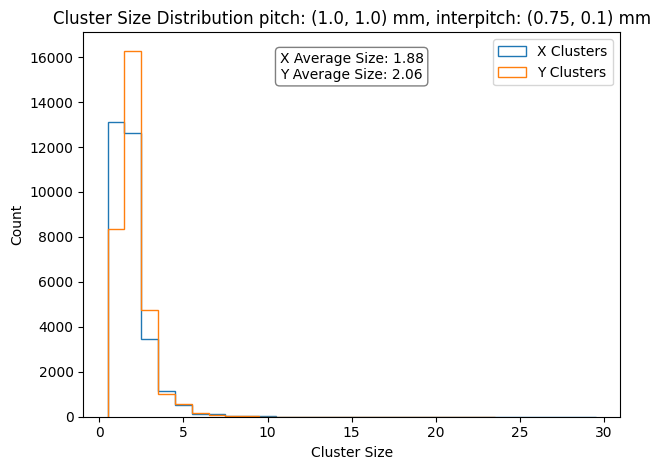

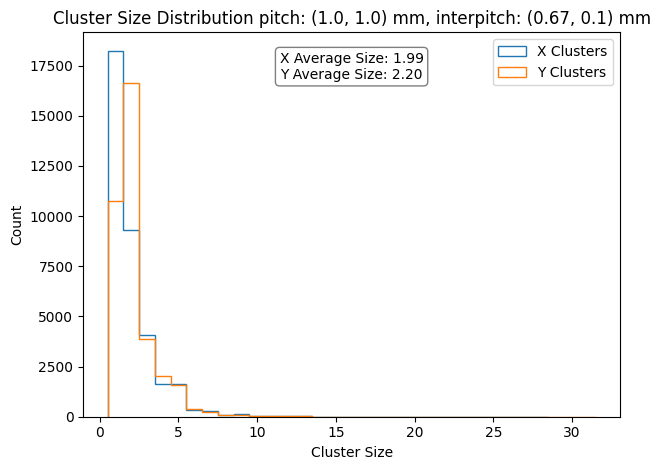

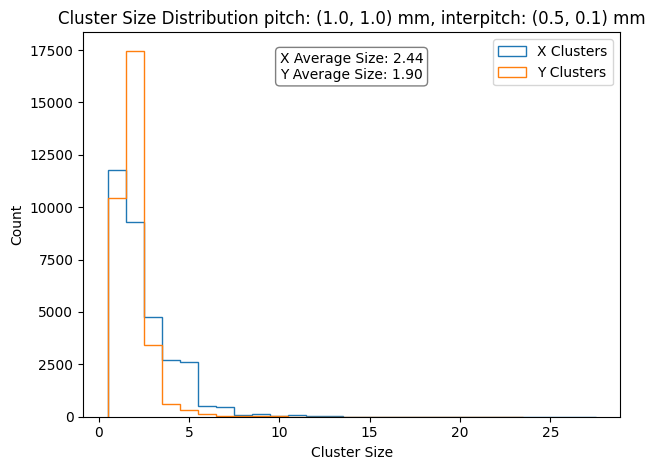

In [23]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

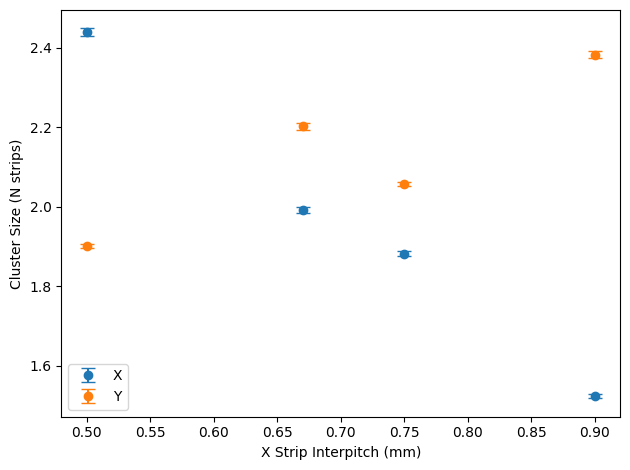

In [24]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

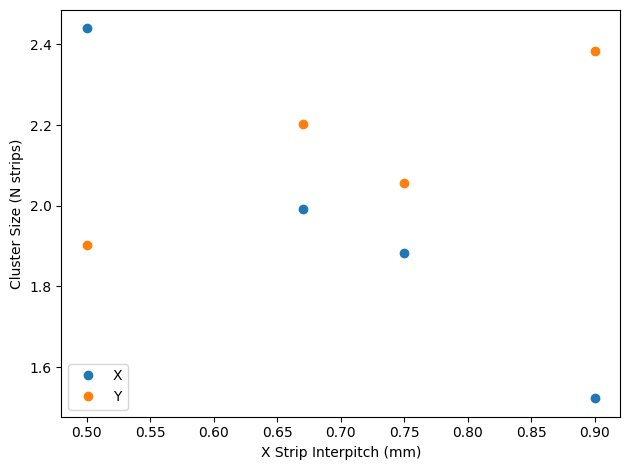

In [25]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [26]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

scan_res min: 0.22002764007429118, max: 0.8170009278286826
res_vmax: 0.653209441123773
mean_vmin: -0.111107045394256, mean_vmax: 0.12927375110060302


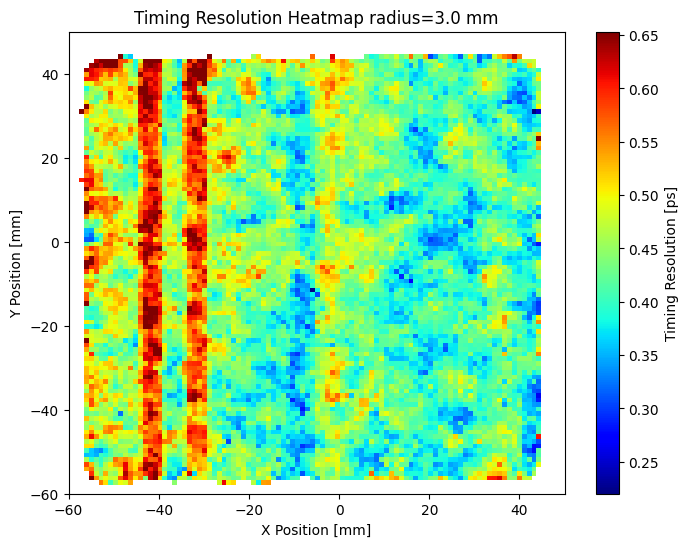

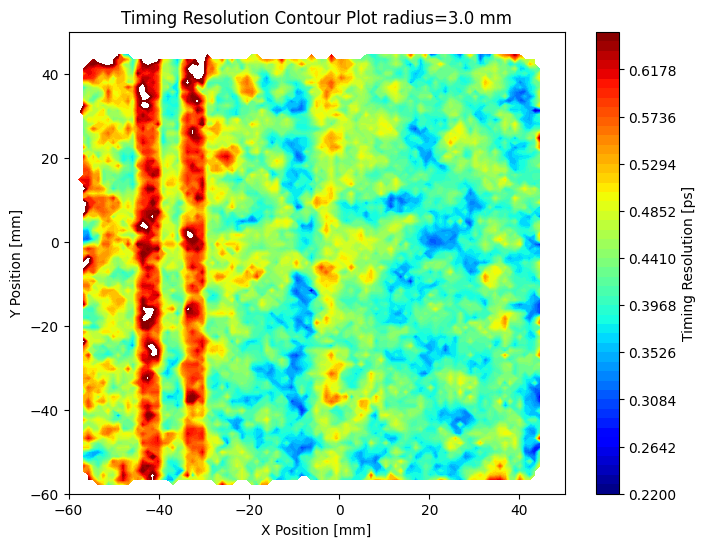

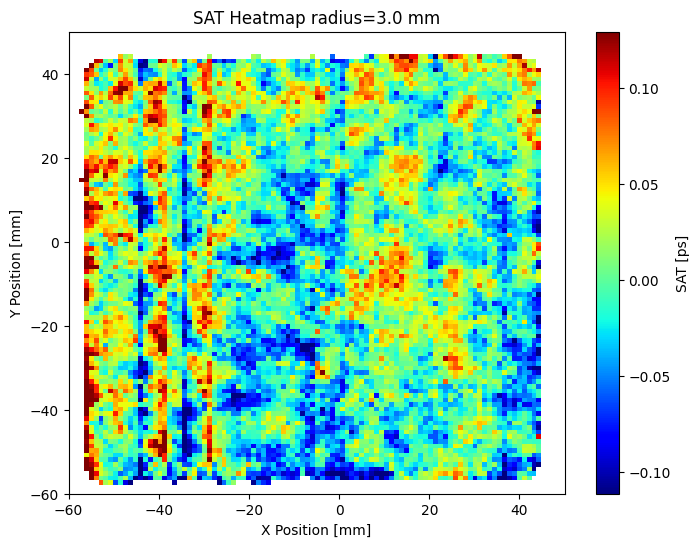

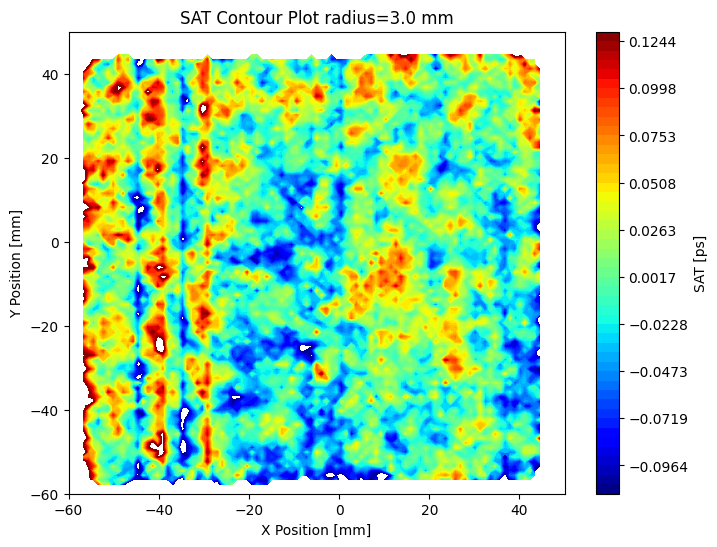

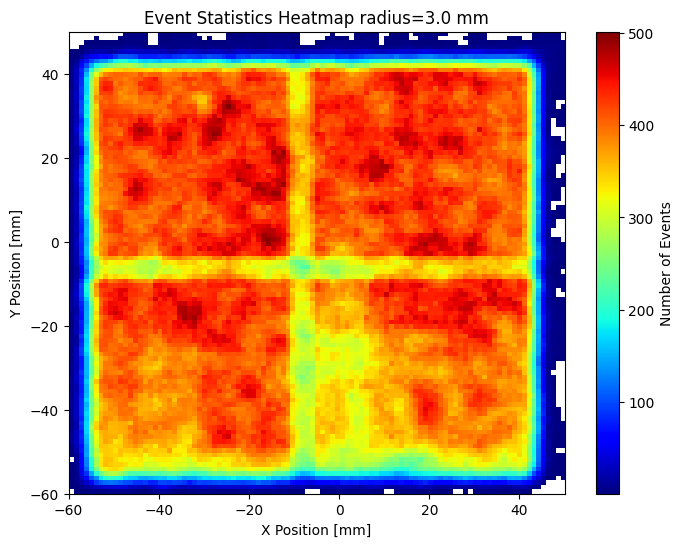

In [27]:
scan_xs = np.linspace(-60, 50, 100 + 1)
scan_ys = np.linspace(-60, 50, 100 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 3

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99))

scan_res min: 0.2660872935415288, max: 1.619056822432197
res_vmax: 0.618775228118129
mean_vmin: -0.12703932039179042, mean_vmax: 0.13989148088251951


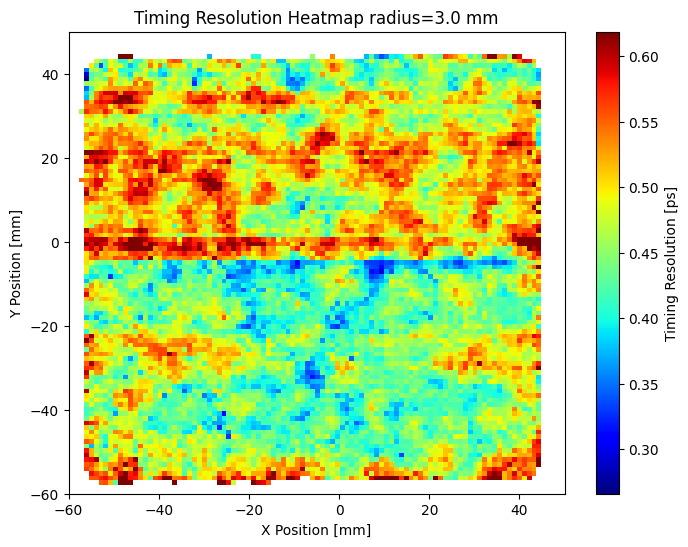

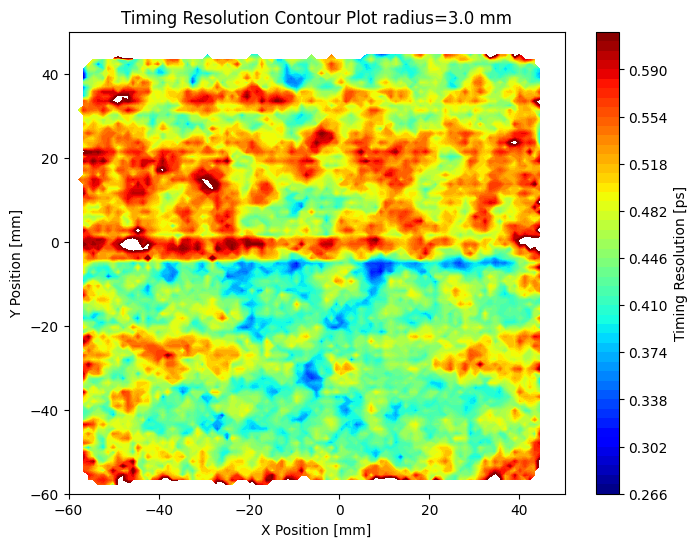

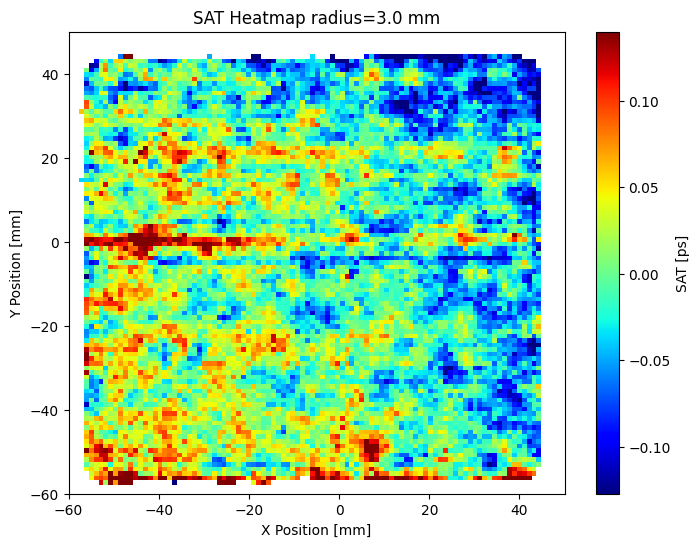

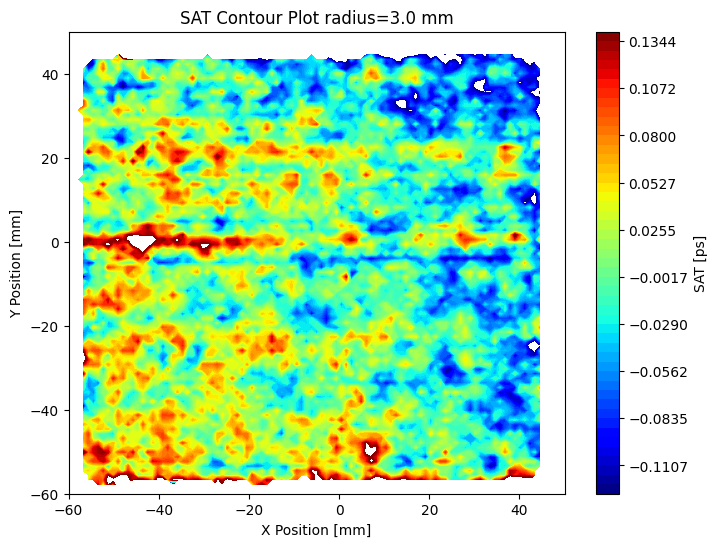

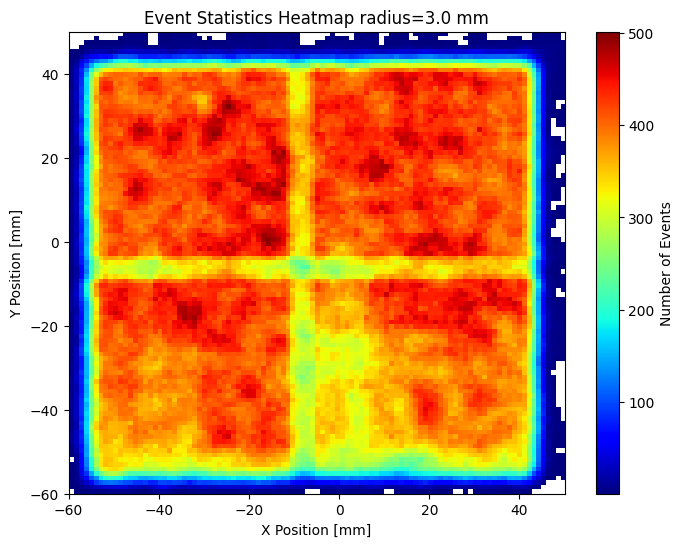

In [28]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99))